In [124]:
import numpy as np
import rasterio
import rasterio.plot
import matplotlib as mpl
import matplotlib.pyplot as plt

from affine import Affine
from copy import copy

%matplotlib inline

In [125]:
import popfill.loader
import popfill.kernel

In [126]:
# small subset
# mask_file = "data/mask_clip_simple.tif"
# population_file = "data/pop_clip_simple.tif"

# large subset
mask_file = "data/mask_clip.tif"
population_file = "data/pop_clip.tif"

In [127]:
loader = popfill.loader.PopulationLoader()
mask, population = loader.load(mask_file, population_file)

# Initial visualization of input data

Let's look at the mask first

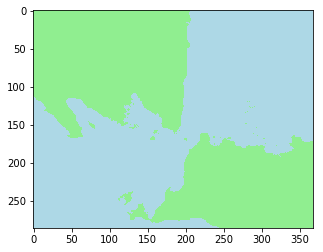

In [128]:
# define color map for mask plotting
mask_color = mpl.colors.ListedColormap(['lightgreen'])
mask_color.set_bad(color='lightblue')

plt_data = np.ma.masked_where(mask.data == False, mask.data)
plt.imshow(plt_data,interpolation='none',cmap=mask_color)

How about the population data?

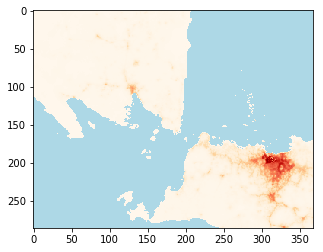

In [129]:
pop_color = copy(plt.cm.OrRd)
pop_color.set_bad(color='lightblue')

plt_data = np.ma.masked_where(population.data == np.nan, population.data)
plt.imshow(plt_data,interpolation='none',cmap=pop_color)

In [130]:
pop_re = population.data.astype(np.int)
pop_re[~np.isnan(population.data)] = 20;
pop_re[np.isnan(population.data)] = 10;
pop_re = pop_re.astype(np.int)

In [131]:
mask_re = mask.data.astype(np.int)
mask_re[mask.data==1] = 2;
mask_re[mask.data==0] = 1;

In [132]:
class_re = pop_re + mask_re

In [133]:
T0 = mask.profile['transform']
T1 = T0*Affine.translation(0.5, 0.5) # Get affine transform for pixel centers

# Function to convert pixel row/column index (from 0) to easting/northing at center
rc2xy = lambda r, c: (c, r) * T1

In [134]:
col = np.arange(mask_re.shape[1])
row = np.arange(mask_re.shape[0])
cols, rows = np.meshgrid(col, row)

x, y = rc2xy(rows, cols)

In [135]:
rows[class_re==12]

array([107, 120, 122, 126, 126, 127, 127, 127, 133, 134, 148, 148, 154,
       154, 161, 162, 162, 162, 164, 164, 166, 167, 167, 167, 167, 167,
       167, 167, 168, 168, 168, 168, 168, 168, 168, 168, 168, 168, 168,
       169, 169, 169, 169, 169, 170, 170, 170, 170, 170, 170, 170, 170,
       170, 171, 171, 171, 171, 171, 172, 172, 172, 172, 173, 173, 173,
       174, 174, 174, 174, 174, 174, 174, 175, 175, 175, 175, 175, 175,
       176, 176, 176, 177, 177, 177, 177, 177, 177, 178, 178, 179, 180,
       180, 180, 181, 182])

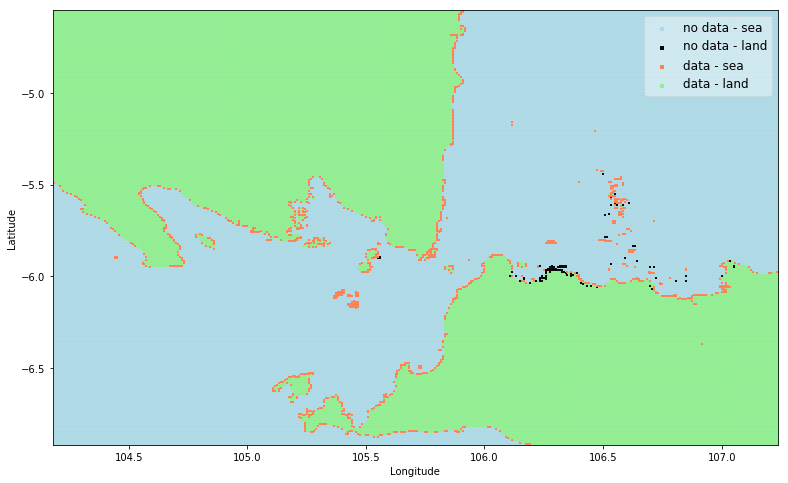

In [136]:
plt.figure(figsize=(13,8))
h1 = plt.scatter(x[class_re==11], y[class_re==11], 1, c = 'lightblue', marker = u's')
h4 = plt.scatter(x[class_re==22], y[class_re==22], 1, c = 'lightgreen', marker = u's')
h2 = plt.scatter(x[class_re==12], y[class_re==12], 1, c = 'black', marker = u's')
h3 = plt.scatter(x[class_re==21], y[class_re==21], 1, c = 'coral', marker = u's')


plt.legend((h1,h2,h3,h4),('no data - sea','no data - land','data - sea','data - land'),
           fontsize='large',markerscale=3,fancybox=True,framealpha=0.4,loc=1)
plt.ylabel('Latitude')
plt.xlabel('Longitude')
plt.xlim(x[0,0],x[-1,-1])
plt.ylim(y[-1,-1],y[0,0]);

In [137]:
unique, counts = np.unique(class_re, return_counts=True)

([<matplotlib.axis.XTick at 0x127611da0>,
 <a list of 4 Text xticklabel objects>)

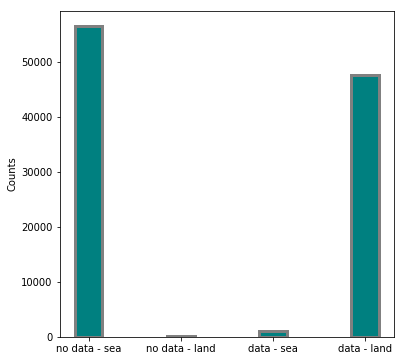

In [138]:
# bar plot to show the counts of different pixel interactions
plt.figure(figsize=(6,6))

plt.ylabel('Counts')
plt.bar(np.arange(4),counts,.3,align='center',color='teal',edgecolor='grey',linewidth=3)
plt.xticks(np.arange(4), ('no data - sea','no data - land','data - sea','data - land'))


In [139]:
filler = popfill.kernel.Basic(mask.data, population.data)
filled_pop = filler.fill()

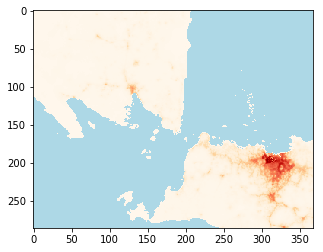

In [140]:
plt.imshow(new_pop,interpolation='none',cmap=pop_color)

In [116]:
old_pop = population.data.copy()
old_pop[rows[class_re==12], cols[class_re==12]] = 0 # black points

new_pop = filled_pop.copy()
new_pop[rows[class_re==21], cols[class_re==21]] = 0 # red points

pop_diff = new_pop - old_pop

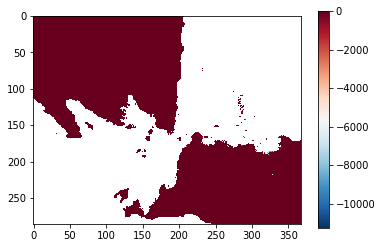

In [117]:
# plt.imshow(pop_diff,interpolation='none',cmap='RdBu_r')
plt.contourf(x,y,pop_diff,interpolation='none',cmap='RdBu_r',linestyles='None')
c_max = np.max(np.abs(diff)) # find the largest difference in magnitude
plt.clim(-c_max, c_max)
plt.colorbar()
plt.title('New Population - Old Population')


In [147]:

plt.contourf?
